# Классификация музыкальных произведений по жанрам

## Подготовка данных

### Импорт библитек

In [1]:
!pip install feature-engine
!pip install phik
!pip install scikit-learn==1.1.3
!pip install --upgrade scikit-learn
!pip install catboost==<desired_version> --install-option="--with-gpu"

  Using cached scikit_learn-1.1.3-cp38-cp38-macosx_10_9_x86_64.whl (8.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
  Using cached scikit_learn-1.3.2-cp38-cp38-macosx_10_9_x86_64.whl (10.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3


    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3
zsh:1: no such file or directory: desired_version


In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from phik import report

from collections import Counter

from sklearn.metrics import (
    f1_score,
    make_scorer)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from catboost import CatBoostClassifier
from feature_engine.imputation import CategoricalImputer

import warnings
warnings.filterwarnings('ignore')

### Загрузка данных

In [3]:
# Загрузим файлы с тренировочной выборкой (kaggle_music_genre_train.csv) и тестовой (kaggle_music_genre_test.csv)
try:
    data_train = pd.read_csv('/Users/lena/kaggle_music_genre_train.csv')
    data_test = pd.read_csv('/Users/lena/kaggle_music_genre_test.csv')
except:
    data_train = pd.read_csv('/kaggle/input/music-genre-prediction-m120ds/kaggle_music_genre_train.csv')
    data_test = pd.read_csv('/kaggle/input/music-genre-prediction-m120ds/kaggle_music_genre_test.csv')

In [4]:
# Откроем датасет с тренировочной выборкой data_train
data_train.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [5]:
# Откроем датасет с тестовой выборкой data_test
data_test.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121


## Исследовательский анализ данных

In [6]:
# Посмотрим информацию data_train
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [7]:
# Посмотрим информацию data_test
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


Датасет data_train содержит 16 колонок и 20394 значений.  
Датасет data_test содержит 15 колонок и 5099 значений (отсутствует целевой признак 'music_genre').  

Все признаки можно разбить на:  


**Количественные признаки:**
  
* acousticness - акустичность  
* danceability - танцевальность  
* duration_ms -продолжительность в милисекундах  
* energy - энергичность  
* instrumentalness - инструментальность  
* liveness - привлекательность  
* loudness - громкость  
* speechiness - выразительность  
* tempo - темп  
* valence - привлекательность произведения для пользователей сервиса  

**Качественные признаки**

* instance_id - уникальный идентификатор трека
* track_name - название трека  
* key - базовый ключ (нота) произведения  
* mode - указывает на модальность (мажорную или минорную) трека  
* obtained_date - дата загрузки в сервис  
* music_genre - музыкальный жанр  

In [8]:
# Проверим количество пропущенных значений
data_train.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

In [9]:
# Проверим наличие явных дубликатов
data_train.duplicated().sum()

0

### Баланс классов

Проверим баланс классов в целевом признаке 'music_genre'

In [10]:
data_train['music_genre'].value_counts()

Blues          2858
Alternative    2601
Electronic     2564
Rap            2428
Rock           2165
Country        2120
Anime          1901
Classical      1373
Jazz           1239
Hip-Hop        1145
Name: music_genre, dtype: int64

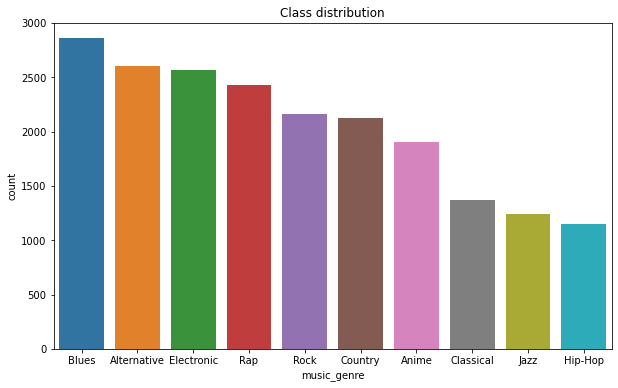

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data_train, 
              x='music_genre',
              order=data_train['music_genre'].value_counts().index)
plt.title("Class distribution")
plt.show()

Классы не сбалансированы. Композиций жанров блюз, альтернативного рока, электроники значительно больше6 чем классики, джаза и хип-хопа.

In [12]:
#Разделим признаки по типам: целевой признак, числовые и категориальные значения

target_col = 'music_genre'
exclude_cols = [target_col, 'instance_id', 'track_name'] 

# Числовые признаки
num_cols = data_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in exclude_cols]

# Категориальные признаки
cat_cols = data_train.select_dtypes(exclude=[np.number]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in exclude_cols]

num_cols, cat_cols

(['acousticness',
  'danceability',
  'duration_ms',
  'energy',
  'instrumentalness',
  'liveness',
  'loudness',
  'speechiness',
  'tempo',
  'valence'],
 ['key', 'mode', 'obtained_date'])

### Анализ числовых признаков

Проведем анализ числовых признаков

In [13]:
# Выведем общую статистическую информация о всех числовых признаках
data_train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,20394.0,0.274783,0.321643,0.00000,0.01520,0.120000,0.470000,0.996
danceability,20394.0,0.561983,0.171898,0.06000,0.45100,0.570000,0.683000,0.978
duration_ms,20394.0,220375.425272,126728.326142,-1.00000,177517.00000,219533.000000,266000.000000,4497994.000
energy,20394.0,0.625276,0.251238,0.00101,0.47000,0.666000,0.830000,0.999
instrumentalness,20394.0,0.159989,0.306503,0.00000,0.00000,0.000144,0.084475,0.996
liveness,20394.0,0.198540,0.166742,0.01360,0.09730,0.130000,0.253000,1.000
loudness,20394.0,-8.552998,5.499917,-44.40600,-10.25575,-7.052000,-5.054000,3.744
speechiness,20394.0,0.091352,0.097735,0.02230,0.03560,0.049050,0.095575,0.942
tempo,19952.0,120.942522,30.427590,34.76500,95.92175,120.012500,141.966250,220.041
valence,20394.0,0.464588,0.243387,0.00000,0.27200,0.457000,0.653000,0.992


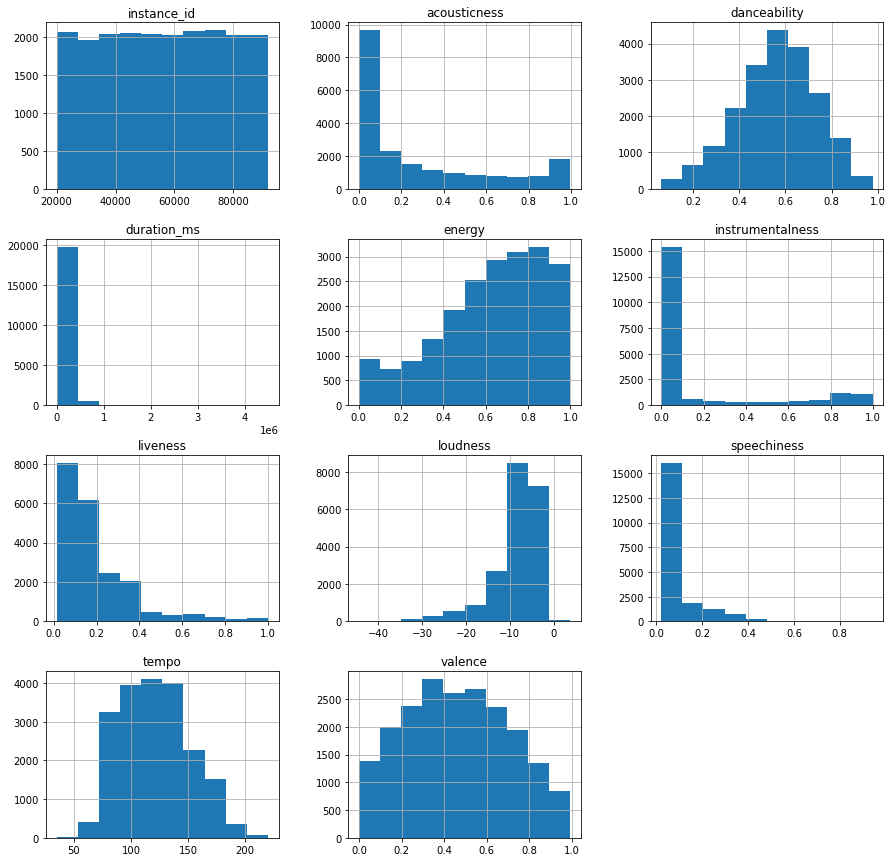

In [14]:
#Гистограмма для датасета data_train
data_train.hist(figsize=(15, 15));

Данные стремятся к нормальному распределению у признаков:  

* danceability - танцевальность  
* tempo - темп  
* valence - привлекательность произведения для пользователей сервиса  

Есть выбросы у некоторых количественных значений:  
 
* acousticness - акустичность  
* duration_ms -продолжительность в милисекундах  
* instrumentalness - инструментальность  
* liveness - привлекательность  
* loudness - громкость  
* speechiness - выразительность  
  
Аномалия, бросающаяся в глаза с отрицательным значением.  

* duration_ms  

Исследуем распределение числовых признаков по музыкальным жанрам

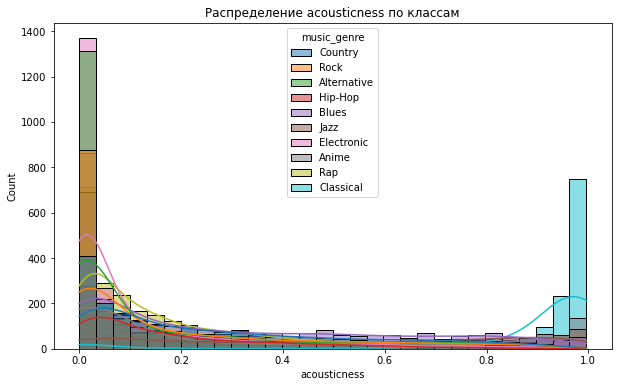

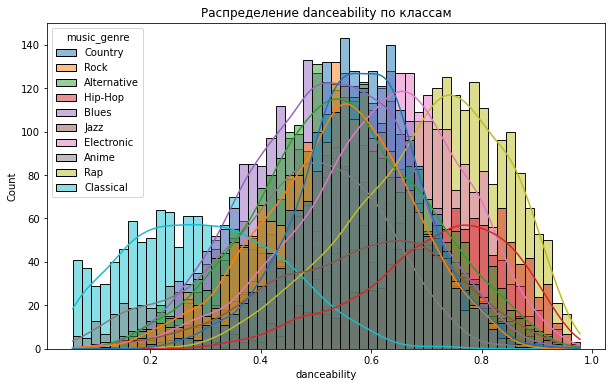

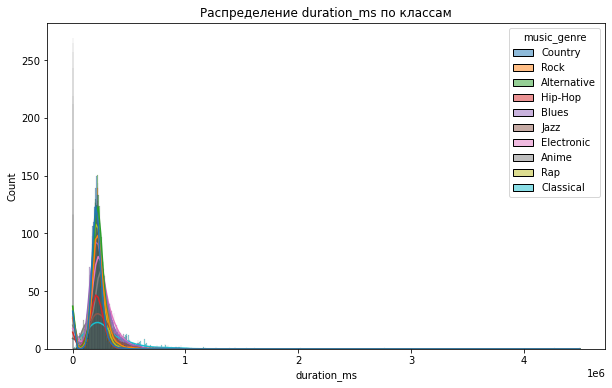

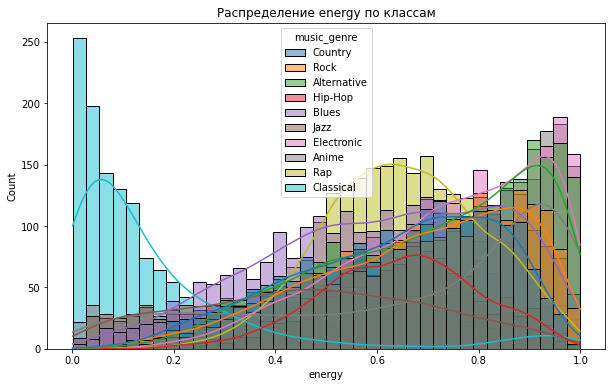

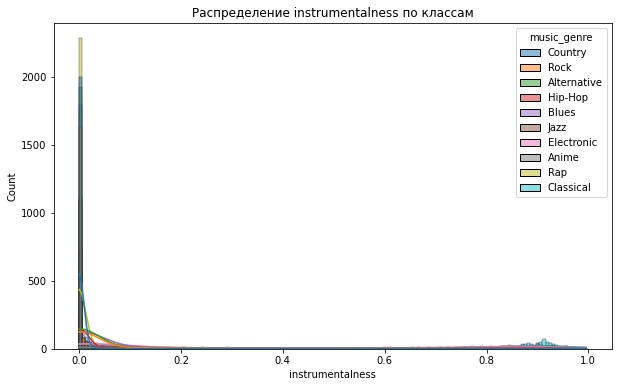

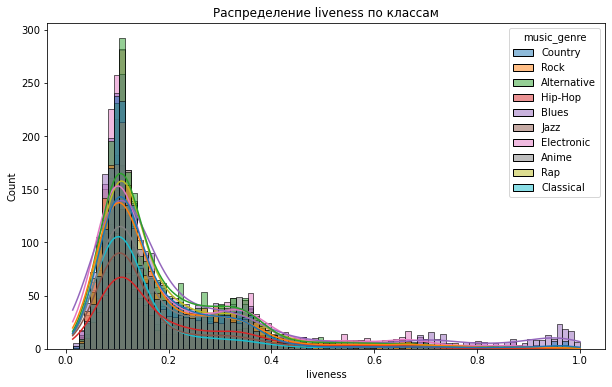

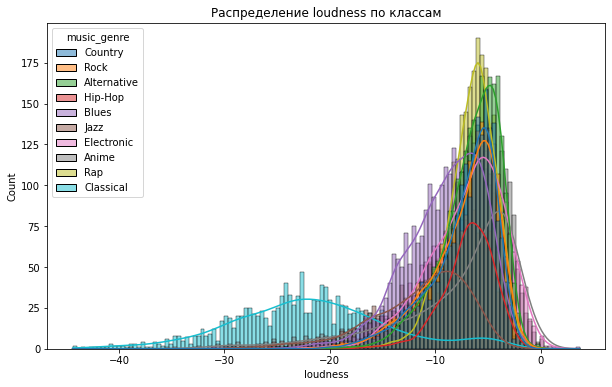

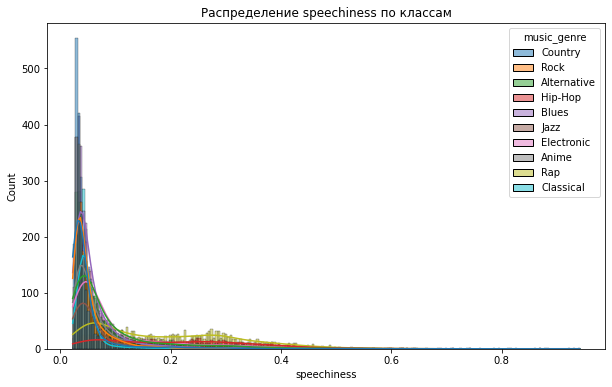

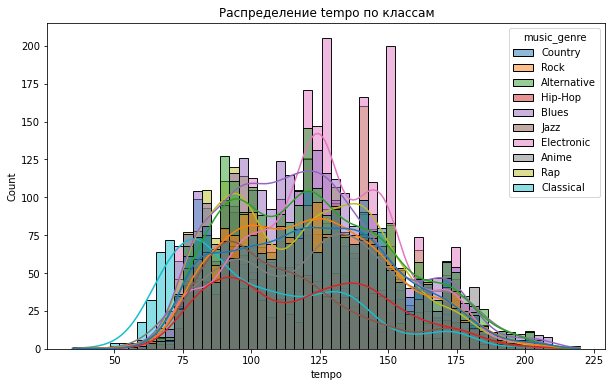

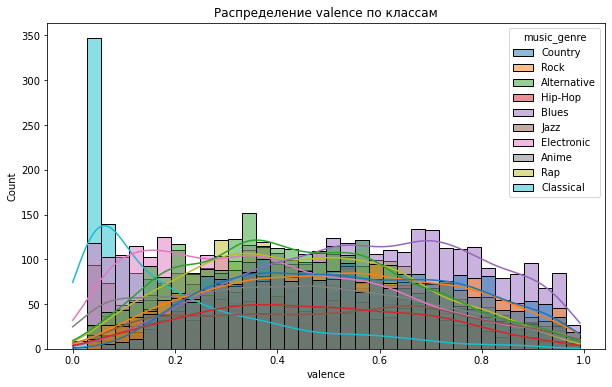

In [15]:
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data_train, x=col, hue=target_col, kde=True, palette="tab10")
    plt.title(f"Распределение {col} по классам")
    plt.show()

Построим графики boxplot для каждого числового признака

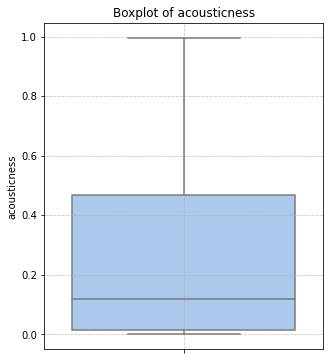

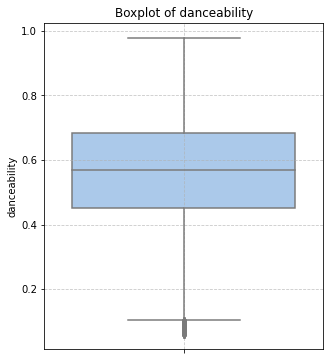

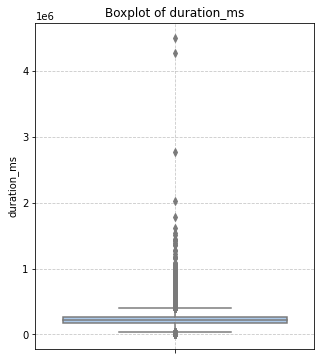

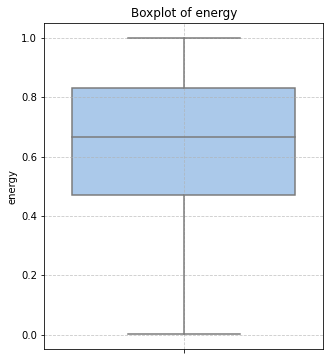

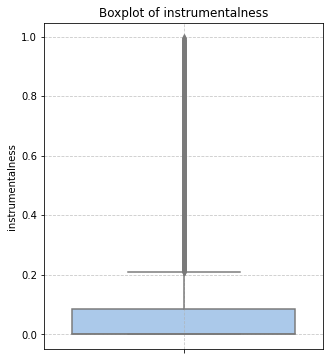

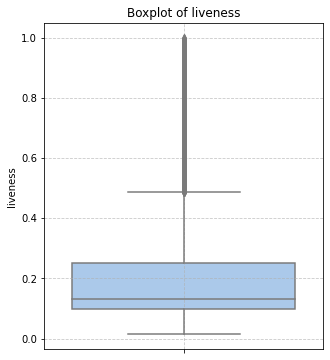

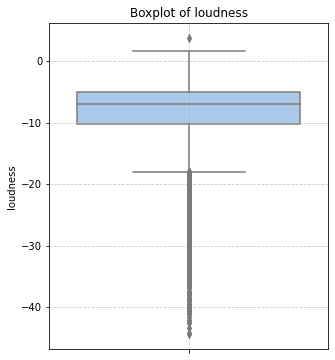

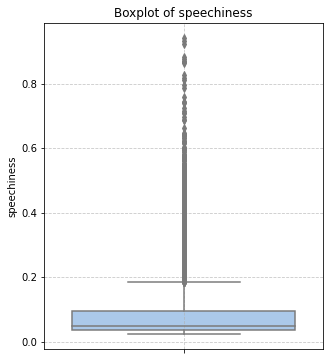

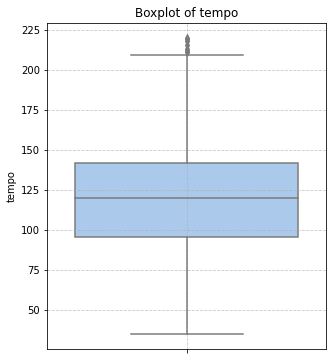

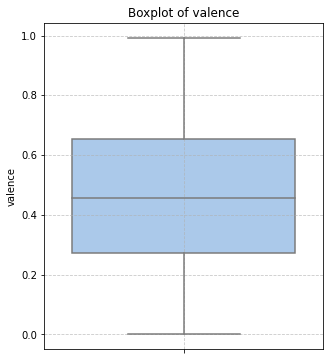

In [16]:
for col in num_cols:
    plt.figure(figsize=(5,6))
    ax = sns.boxplot(data=data_train, y=col, palette="pastel")
    plt.title(f"Boxplot of {col}")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

Построим графики boxplot для числовых признаков с разбивкой по музыкальным жанрам

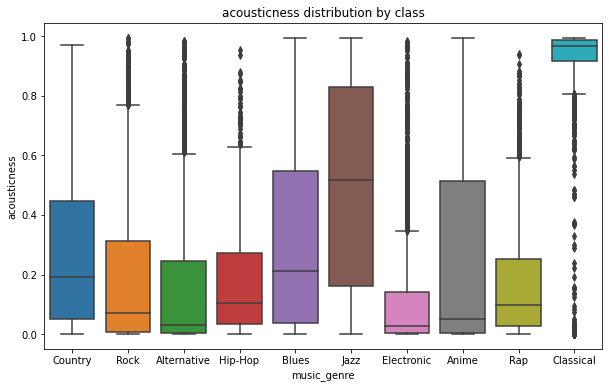

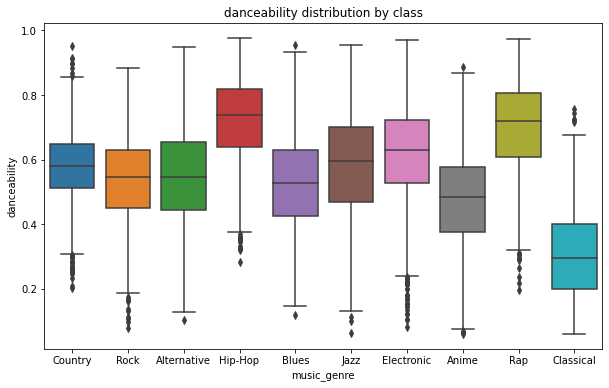

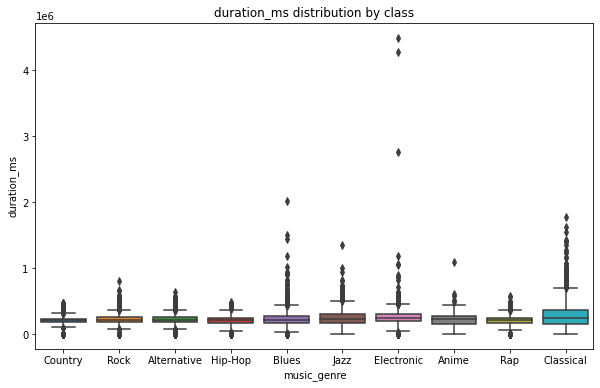

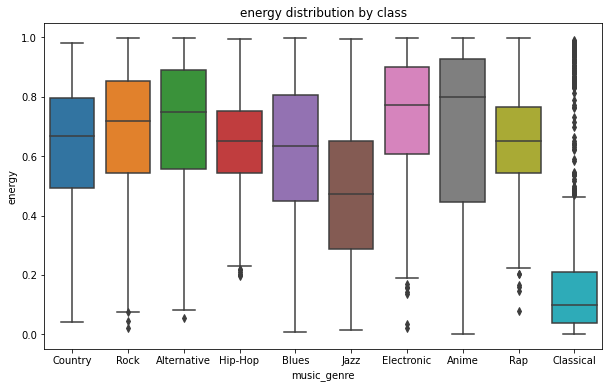

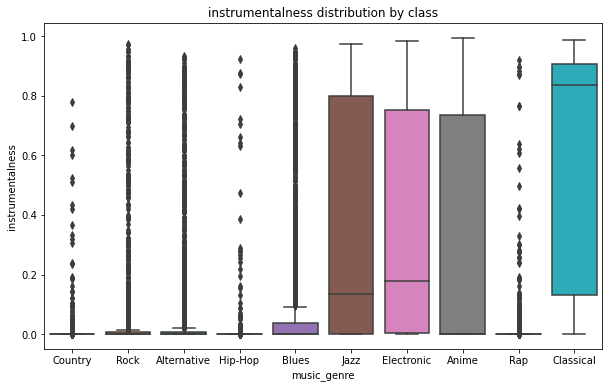

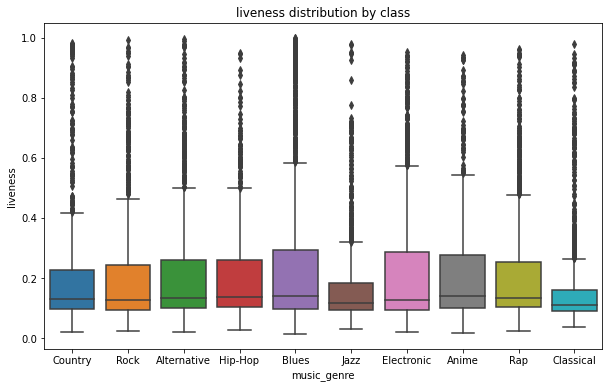

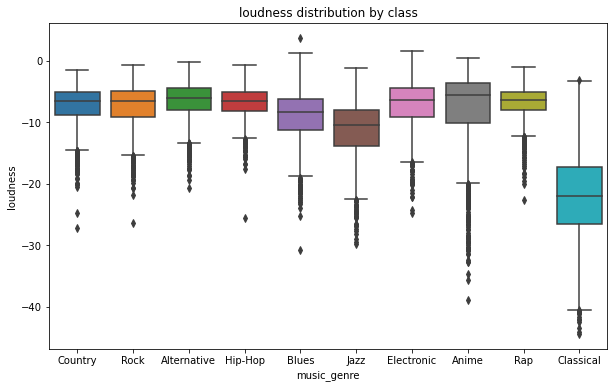

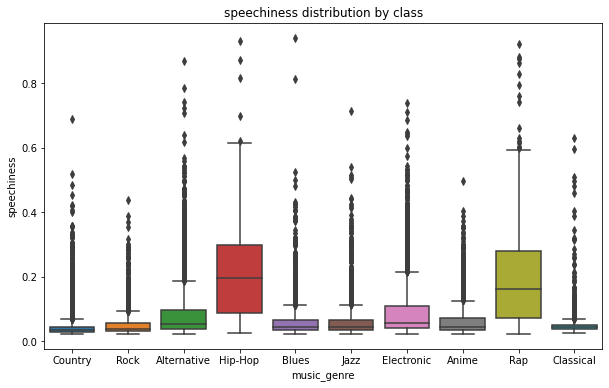

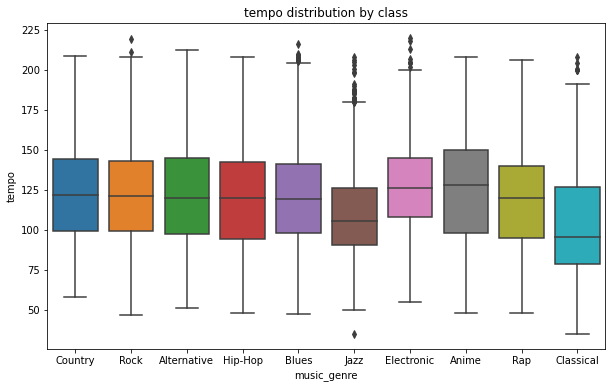

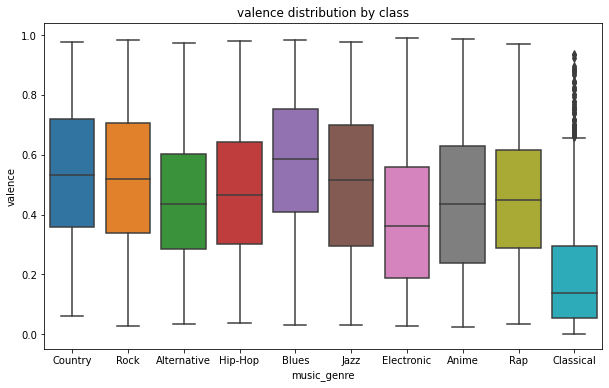

In [17]:
num_cols_for_viz = num_cols
for col in num_cols_for_viz:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data_train, x=target_col, y=col, palette="tab10")
    plt.title(f"{col} distribution by class")
    plt.show()

Построим графики violinplot для каждого числового признака

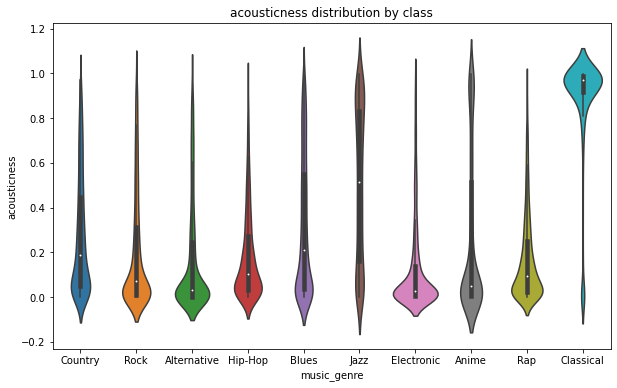

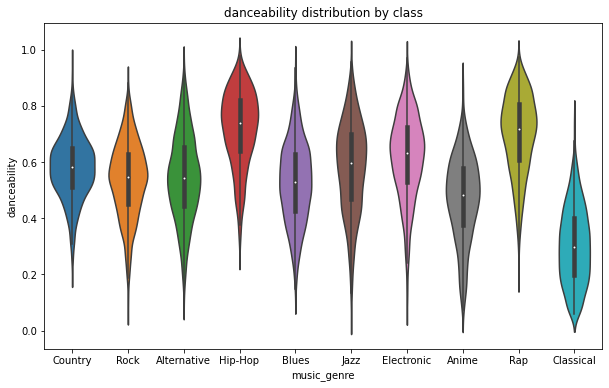

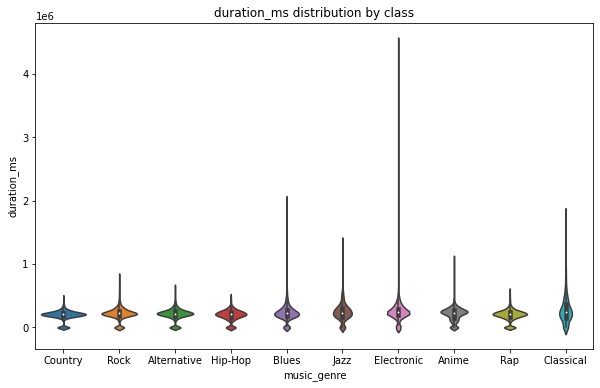

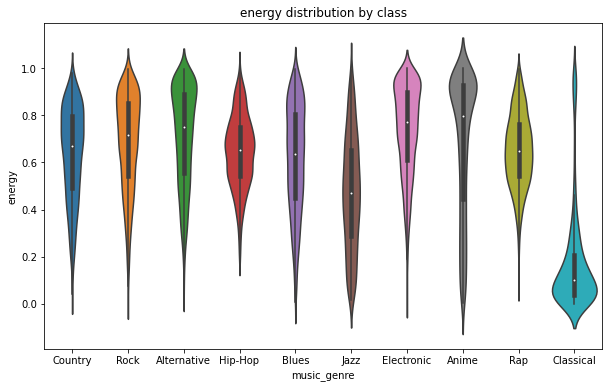

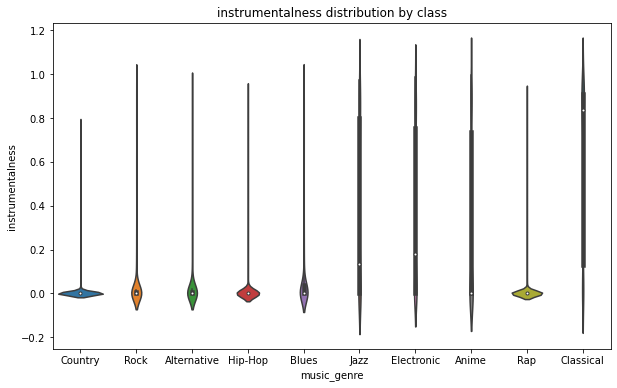

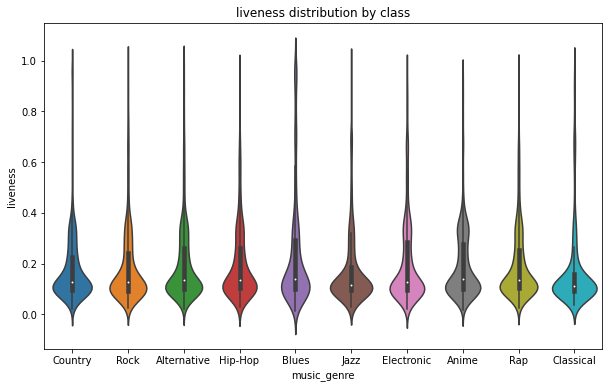

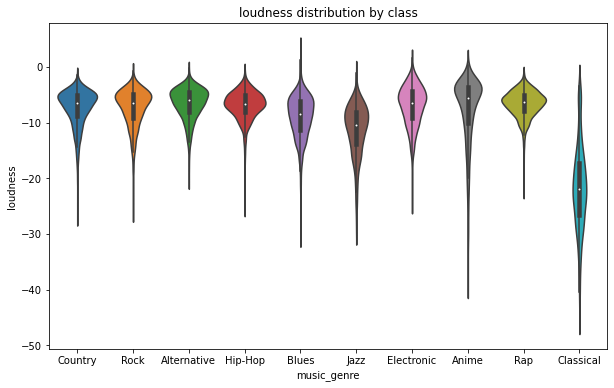

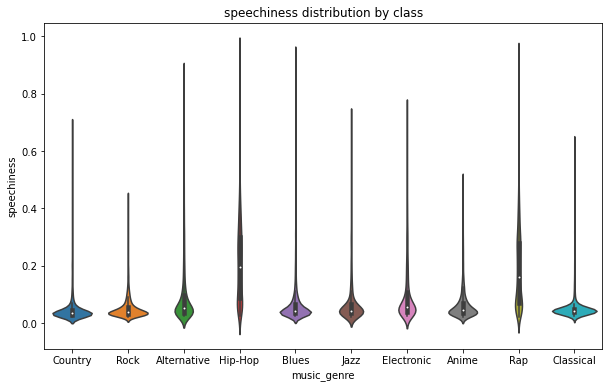

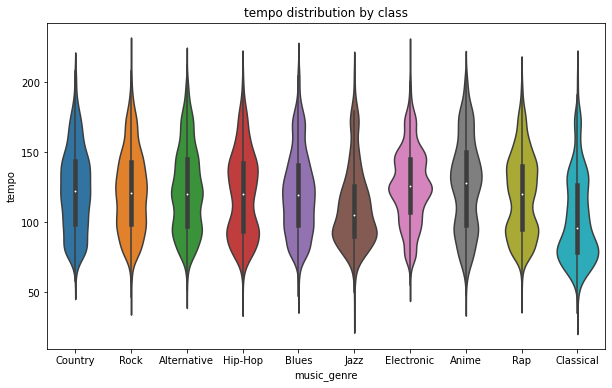

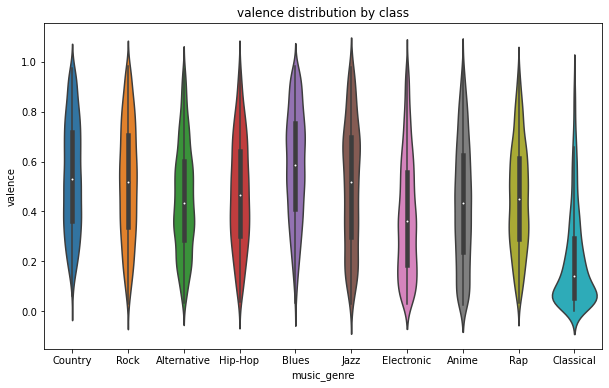

In [18]:
num_cols_for_viz = num_cols

for col in num_cols_for_viz:
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=data_train, x=target_col, y=col, palette="tab10")
    plt.title(f"{col} distribution by class")
    plt.show()

Посмотрим количество отрицательных значений в колонке 'duration_ms'

In [19]:
data_train['duration_ms'].value_counts()

-1.0         2009
 240000.0      16
 192000.0      16
 180000.0      13
 182400.0      10
             ... 
 196774.0       1
 192009.0       1
 249387.0       1
 231231.0       1
 316433.0       1
Name: duration_ms, Length: 13649, dtype: int64

Скорее всего значением "-1" были обозначены пропущенные значения. Не будем удалять их из датасета

У признака признак 'loudness' есть значения больше 0 дБ, что нетипично для аудио-треков.
В цифровом аудио 0 дБ — это обычно максимальный уровень без искажений (пиковая громкость).
Значения выше 0 дБ — это либо ошибка измерения, либо артефакт (например, перекодировка).

Удалим все значения loudness > 0, скорее всего это артефакты, а не реальные данные.

In [20]:
# Удалим выбросы
data_train = data_train.drop(data_train[data_train['loudness'] > 0].index)

* Acousticness (акустичность) — значения лежат в диапазоне от 0 до 1. Большая часть жанров и треков находится в интервале 0–0.2. Ярко выделяется классическая музыка, для которой акустичность в основном находится в диапазоне 0.8–1.0.

  
* Danceability (танцевальность) — значения в диапазоне от 0 до 1. Большая часть жанров и треков сосредоточена около 0.56. Классическая музыка характеризуется низкой танцевальностью (0–0.3). Наибольшие значения танцевальности наблюдаются у рэпа и хип-хопа (0.6–0.8).
  
  
* Duration_ms (длительность трека) — средняя длительность составляет 0.561983 ms (значение нормализованное). Самые продолжительные композиции характерны для электронной музыки, классики, блюза и джаза.
  
  
* Energy (энергичность) — диапазон от 0 до 1. Наименее энергичная — классическая музыка (0–0.2), средний уровень энергичности у блюза, рэпа и джаза. Наиболее энергичны альтернативный рок, рок, аниме и электронная музыка (0.6–1.0).  
  
  
* Instrumentalness (инструментальность) — диапазон от 0 до 1. Наибольшая инструментальность у классической музыки (0.8–1.0). Для большинства жанров значения находятся в диапазоне 0–0.1.
  
  
* Speechiness (речевая выразительность) — диапазон от 0 до 1. Большинство жанров и треков имеют значения 0–0.2. Выше всего речевая выразительность у рэпа (0.1–0.5).


* Loudness (громкость) — значения в диапазоне от –44 до 3.7 dB. Большинство треков находятся в пределах –10 до 0 dB. Наиболее тихая музыка — классическая (–44 до –20 dB).


* Liveness (эффект «живого» исполнения) — диапазон от 0 до 1. Большая часть жанров и треков сосредоточена в пределах 0–0.1.


* Tempo (темп) — значения от 34.8 до 220 BPM. Средний темп составляет 120.9 BPM. Классическая музыка отличается более низким темпом (50–70 BPM).


* Valence (позитивность/эмоциональная окраска) — диапазон от 0 до 1. Большинство значений распределены равномерно. Классическая музыка выделяется низкими значениями (0–0.1).

### Анализ категориальных признаков

Рассмотрим категориальные признаки

G     2304
C     2148
C#    2122
D     2110
A     2011
F     1613
B     1519
E     1514
G#    1266
A#    1223
F#    1206
D#     606
Name: key, dtype: int64


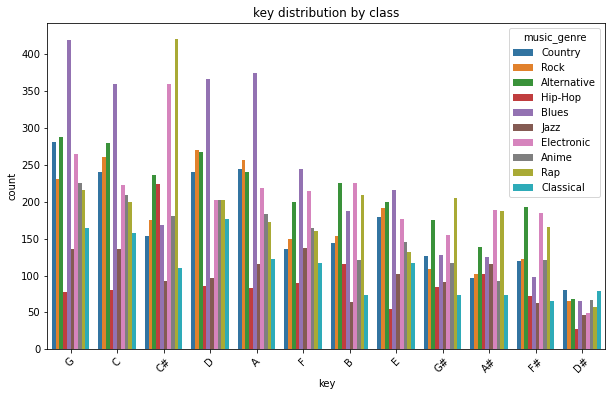

Major    12820
Minor     7051
Name: mode, dtype: int64


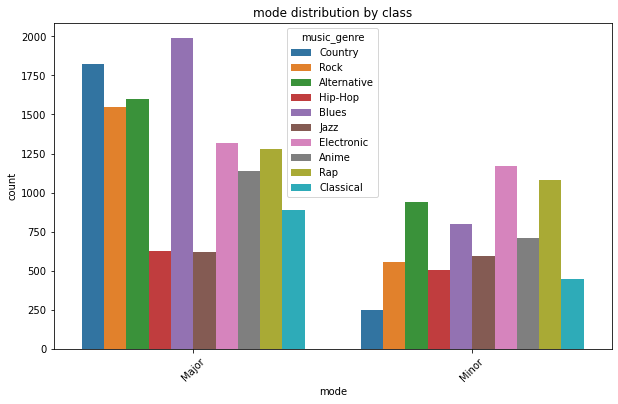

4-Apr    18418
3-Apr     1524
5-Apr      290
1-Apr      145
Name: obtained_date, dtype: int64


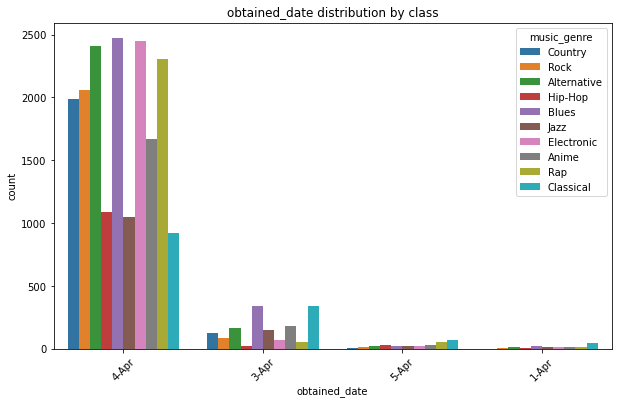

In [21]:
for col in cat_cols:
    print(data_train[col].value_counts())
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data_train, 
                  x=col, 
                  hue=target_col, 
                  order=data_train[col].value_counts().index)
    plt.title(f"{col} distribution by class")
    plt.xticks(rotation=45)
    plt.show()

In [22]:
data_train['track_name'].value_counts()

Home                          11
Diamonds                       7
Summertime                     7
Dreams                         6
Forever                        6
                              ..
Chameleon                      1
No Geography                   1
Lost In You                    1
Will You Love Me Tomorrow?     1
We Don't Deserve Love          1
Name: track_name, Length: 18626, dtype: int64

* Key - будем считать, что все базовые ключи (ноты) уникальны.

Знак '#' на 'диез' в Википедии: "В музыкальной нотации дие́з — знак альтерации, обозначающий повышение стоящих 
справа от него нот на один хроматический полутон. Ставится либо после ключа, либо перед отдельными нотами. 
В первом случае действует до следующего ключа, во втором — до конца такта или явной отмены знаком бекар. 
Диез обозначается решёткой #".

Большинство треков и жанров с ключами G, C, C#, D, A.

* Mode - большинстов треков в датасете в Major. Кантри, рок, альтернативный рок и блюз - преимущественно Major. 


* Obtained_date - дата загрузки в сервис. Всего 4 даты (1, 3, 4, 5 апреля). Признак не несет полезной информации, в дальнейшем мы его удалим.


* Track_name - текстовые значения. Практически все значения уникальны. Встречаются повторяющиеся названия композиций, это вполне вероятно (у разных групп или артистов могут выходить треки с одинаковыми заголовками)

In [23]:
data_train.duplicated().sum()

0

In [24]:
# Посмотрим информацию data_train
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20377 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20377 non-null  float64
 1   track_name        20377 non-null  object 
 2   acousticness      20377 non-null  float64
 3   danceability      20377 non-null  float64
 4   duration_ms       20377 non-null  float64
 5   energy            20377 non-null  float64
 6   instrumentalness  20377 non-null  float64
 7   key               19642 non-null  object 
 8   liveness          20377 non-null  float64
 9   loudness          20377 non-null  float64
 10  mode              19871 non-null  object 
 11  speechiness       20377 non-null  float64
 12  tempo             19936 non-null  float64
 13  obtained_date     20377 non-null  object 
 14  valence           20377 non-null  float64
 15  music_genre       20377 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

### Проверка значений на мультиколлинеарность

Будем использовать phik, так как он позволяет обнаружить корреляцию не только между количественными, но и между качественными признаками

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


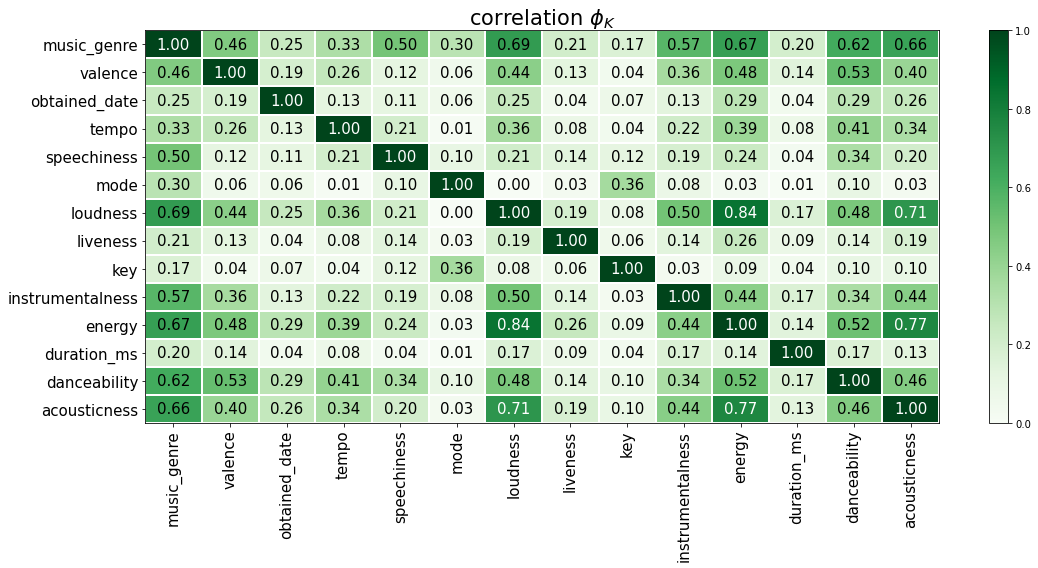

In [25]:
# Удалим 'instance_id' и 'track_name', чтобы не усложнять обработку данных

data_temp = data_train.drop(['instance_id', 'track_name'], axis=1)

phik_overview = data_temp.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 8))
plt.tight_layout();

Видим сильную корреляцию между признаками:

* loudness , energy, acousticness и целевой переменной music_genre

Это означает, что данные признаки, вероятно, будут иметь существенное влияние на качество предсказаний модели при обучении.

###  Проверка важности признаков (Mutual Information)

Проверим важность признаков (Mutual Information) до обучения моделей, чтобы понять, какие признаки потенциально несут полезную информацию о таргете ещё до запуска сложных алгоритмов.

* Измеряет, насколько знание признака уменьшает неопределённость таргета.
* Работает и с нелинейными зависимостями, и с категориальными признаками. Иногда Mutual Information выделяет признаки, которые не линейно влияют на таргет, и которые классические корреляции не видят.
* Помогает определить признаки, которые не несут полезной информации о целевой переменной 

instrumentalness    0.248623
acousticness        0.240228
loudness            0.231250
danceability        0.210774
energy              0.208668
speechiness         0.185921
tempo               0.129936
valence             0.095232
duration_ms         0.087365
obtained_date       0.029137
mode                0.027180
key                 0.023586
liveness            0.023006
dtype: float64


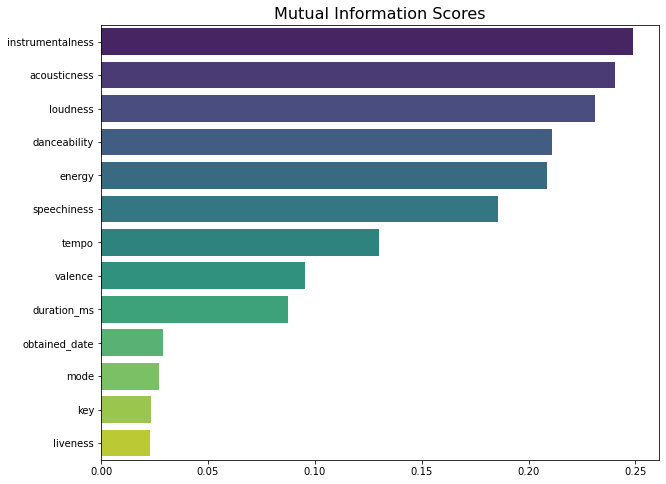

In [26]:
target_col = 'music_genre'
df_enc = data_train.copy()

# Исключим 'instance_id' и 'track_name'
exclude_cols = [target_col, 'instance_id', 'track_name']
all_features = [c for c in df_enc.columns if c not in exclude_cols]

# Заполним пропуски средним для числовых значений и наиболее популярными значениями для категориальных
num_features = df_enc[all_features].select_dtypes(include=['number']).columns.tolist()
cat_features = [c for c in all_features if c not in num_features]

num_imputer = SimpleImputer(strategy='mean')
df_enc[num_features] = num_imputer.fit_transform(df_enc[num_features])

cat_imputer = SimpleImputer(strategy='most_frequent')
df_enc[cat_features] = cat_imputer.fit_transform(df_enc[cat_features])

# Кодируем категориальные признаки
for col in cat_features:
    df_enc[col] = LabelEncoder().fit_transform(df_enc[col].astype(str))

# Кодируем таргет
le = LabelEncoder()
y_encoded = le.fit_transform(df_enc[target_col])

# Mutual Information
mi = mutual_info_classif(
    df_enc[all_features],
    y_encoded,
    discrete_features=[df_enc[c].dtype==int for c in all_features]
)

mi_series = pd.Series(mi, index=all_features).sort_values(ascending=False)
print(mi_series)

plt.figure(figsize=(10, 8))
sns.barplot(x=mi_series.values, y=mi_series.index, palette="viridis")
plt.title("Mutual Information Scores", fontsize=16)
plt.show()

Проверка важности признаков (Mutual Information) показала, что некоторые признаки не несут полезной информации о целевом классе:

* obtained_date
* mode
* key
* liveness

Удалим их, чтобы ускорить обучение моделей.

### Вывод

В ходе исследовательского анализа данных:

* Провели анализ распределения целевого признака music_genre — классы оказались не сбалансированными.

* Изучили числовые признаки:

    * Классическая музыка выделяется высокой акустичностью, низкой энергичностью, низким темпом и громкостью.

    * Рэп и хип-хоп имеют наибольшую танцевальность и речевую выразительность.

    * Электронная музыка, альтернатива и рок характеризуются высокой энергичностью и длительностью треков.

    * Большинство признаков имеют низкие значения (0–0.2) за исключением отдельных жанров.
    
    * Обнаружили и удалили аномалии по признаку loudness (значения > 0).

* Категориальные признаки key и mode отражают музыкальный строй, однако их полезность для прогнозирования ограничена; obtained_date не содержат значимой информации.

* Проверили данные на пропуски, дубликаты и мультиколлинеарность — сильная корреляция отмечена между loudness, energy, acousticness и целевым признаком.

* Оценка важности признаков (Mutual Information) показала, что obtained_date, mode, key и liveness не несут полезной информации о целевом классе, поэтому было принято решение удалить их в дальнейшем для ускорения и упрощения обучения моделей.

## Обучение базовых моделей (Baseline)

Построим базовые модели (Baseline), чтобы проверить минимальный уровень качества, с которым будем сравнивать все последующие улучшения:

* LogisticRegression
* RandomForestClassifier
* CatBoostClassifier

Удалим из датасета признаки: obtained_date, mode, key, liveness, instance_id, track_name

In [27]:
# Разделим признаки на числовые, категориальные и таргет
baseline_cols = ['acousticness', 'danceability', 'duration_ms', 'energy',
                 'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence']
target_col = 'music_genre'

numeric_cols = baseline_cols  # все оставшиеся числовые признаки
categorical_cols = []  # категориальных нет

# Обработка числовых значений, заполним пропуски медианой
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols)
])

X = data_train[baseline_cols]
y = data_train[target_col]

# Словарь моделей
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# Обучение baseline
results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    score = cross_val_score(pipeline, X, y, cv=5, scoring='f1_micro').mean()
    results[name] = score

# Печать результатов
print("Baseline results (F1 Micro):")
for model_name, score in results.items():
    print(f"{model_name}: {score:.4f}")

# Табличка
df_results = pd.DataFrame(list(results.items()), columns=['Model', 'F1 Micro Score'])
display(df_results)

Baseline results (F1 Micro):
Logistic Regression: 0.4041
Random Forest: 0.4531
CatBoost: 0.4692


,Model,F1 Micro Score
0,Logistic Regression,0.404132
1,Random Forest,0.453061
2,CatBoost,0.469206


Обучили базовые модели без гиперпараметров и получили уже неплохие результаты. Лучшую метрику 'f1 micro' 0.469 показала 
модель CatBoostClassifier

## Тюнинг моделей

Попытаемся улучить базовые модели:

* Создадим новые признаки (feature engineering)
* Добавим и отрегулируем гиперпараметры (pipeline, GridSearchCV)

### Создание новых признаков

Создадим новые признаки на основе текстового признака 'track_name':

* Бинарный признак 'has_remix', 1 - если в тексте встречается 'remix' и 0 - если нет
* Бинарный признак 'has_feat', 1 - если в тексте встречается 'feat.' и 0 - если нет
* Бинарный признак 'has_live', 1 - если в тексте встречается 'live' и 0 - если нет
* Бинарный признак 'has_remastered', 1 - если в тексте встречается 'remastered' и 0 - если нет
* Бинарный признак 'has_japanese_chars', 1 - если в тексте встречается японские иероглифы и 0 - если нет
* Бинарный признак 'is_classical_like', 1 - если в тексте встречаются слова ('op.', 'act', 'pt.', 'no.', 'minor', 'bwv', 'major', 'adagio', 'act', 'fp', 'symphony', 'suite', 'sonata') и 0 - если нет
* Числовой признак 'track_name_length' - количеством символов в названии трека

Сделаем биннинг (группировку числовых поддиапазонов в группы (bins)) на основе числовых признаков duration_ms, 'tempo', 'energy', 'valence':

* 'duration_score' 
* 'tempo_score' 
* 'energy_score' 
* 'valence_score' 

In [28]:
# Создадим несколько признаков на основе колонки 'track_name'
data_train['has_remix'] = data_train['track_name'].str.lower().str.contains('remix').astype(int)
data_train['has_feat'] = data_train['track_name'].str.lower().str.contains('feat\.').astype(int)
data_train['has_live'] = data_train['track_name'].str.lower().str.contains('live').astype(int)
data_train['has_remastered'] = data_train['track_name'].str.lower().str.contains('remastered').astype(int)

data_test['has_remix'] = data_test['track_name'].str.lower().str.contains('remix').astype(int)
data_test['has_feat'] = data_test['track_name'].str.lower().str.contains('feat\.').astype(int)
data_test['has_live'] = data_test['track_name'].str.lower().str.contains('live').astype(int)
data_test['has_remastered'] = data_test['track_name'].str.lower().str.contains('remastered').astype(int)

In [29]:
# Функция для проверки японских символов
def contains_japanese(text):
    return 1 if re.search(r'[\u3040-\u30ff\u4e00-\u9faf]', str(text)) else 0

data_train['has_japanese_chars'] = data_train['track_name'].apply(contains_japanese)
data_test['has_japanese_chars'] = data_test['track_name'].apply(contains_japanese)

In [30]:
# Создадим новую колонку с количеством символов в названии трека
data_train['track_name_length'] = data_train['track_name'].apply(len)
data_test['track_name_length'] = data_test['track_name'].apply(len)

In [31]:
# Список слов "классической музыки"
classical_keywords = ['op.', 'act', 'pt.', 'no.', 'minor', 'bwv', 'major', 'adagio', 'act', 'fp', 
                      'symphony', 'suite', 'sonata']

def is_classical_like(title):
    title = title.lower()
    return int(any(kw in title for kw in classical_keywords))

data_train['is_classical_like'] = data_train['track_name'].apply(is_classical_like)
data_test['is_classical_like'] = data_test['track_name'].apply(is_classical_like)

In [32]:
# Сгруппируем жанры по средней длительности треков
data_train.groupby('music_genre')['duration_ms'].mean().sort_values()

music_genre
Hip-Hop        194388.653275
Country        195467.119811
Rap            195752.223641
Alternative    208896.554018
Anime          210120.521624
Rock           215056.658199
Blues          229321.932073
Jazz           243244.999193
Electronic     244567.547377
Classical      284025.983977
Name: duration_ms, dtype: float64

In [33]:
# Создадим признак с группировкой по длительности треков
def duration_score(duration_ms):
    if duration_ms == -1:
        return 0  # отсутствующие значения                    
    elif duration_ms < 2.5 * 60000:
        return 1 # короткие треки
    elif duration_ms < 3.5 * 60000:
        return 2 # средние треки
    elif duration_ms < 4.5 * 60000:
        return 3 # длинные треки
    else:
        return 4 # очень длинные треки

data_train['duration_score'] = data_train['duration_ms'].apply(duration_score)
data_test['duration_score'] = data_test['duration_ms'].apply(duration_score)

In [34]:
# Сгруппируем жанры по среднему темпу
data_train.groupby('music_genre')['tempo'].mean().sort_values()

music_genre
Classical      103.194000
Jazz           111.487687
Rap            119.844867
Hip-Hop        120.450162
Blues          121.328074
Rock           122.419925
Alternative    122.949432
Country        123.220372
Electronic     126.401364
Anime          126.655301
Name: tempo, dtype: float64

In [35]:
# Создадим признак с группировкой по темпам
def tempo_score(tempo):
    if tempo < 110:
        return 1  # медленный
    elif tempo < 125:
        return 2  # средний
    else:
        return 3  # быстрый

data_train['tempo_score'] = data_train['tempo'].apply(tempo_score)
data_test['tempo_score'] = data_test['tempo'].apply(tempo_score)

In [36]:
# Сгруппируем жанры по средней энергичности
data_train.groupby('music_genre')['energy'].mean().sort_values()

music_genre
Classical      0.174565
Jazz           0.471680
Blues          0.613819
Country        0.636092
Hip-Hop        0.644582
Rap            0.652091
Anime          0.674567
Rock           0.683546
Alternative    0.709921
Electronic     0.737238
Name: energy, dtype: float64

In [37]:
# Создадим признак с группировкой по энергичности
def energy_score(energy):
    if energy < 0.45:       # низкая энергичность
        return 1
    elif energy < 0.65:     # средняя энергичность
        return 2
    else:                    # высокая энергичность
        return 3

data_train['energy_score'] = data_train['energy'].apply(energy_score)
data_test['energy_score'] = data_test['energy'].apply(energy_score)

In [38]:
# Сгруппируем жанры по средней привлекательности трека для пользователей сервиса
data_train.groupby('music_genre')['valence'].mean().sort_values()

music_genre
Classical      0.208213
Electronic     0.388475
Anime          0.436239
Alternative    0.449189
Rap            0.456786
Hip-Hop        0.473525
Jazz           0.503369
Rock           0.519957
Country        0.539644
Blues          0.578034
Name: valence, dtype: float64

In [39]:
# Создадим признак с группировкой по привлекательности трека для пользователей сервиса
def valence_score(valence):
    if valence < 0.30:       # очень низкая привлекательность
        return 1
    elif valence < 0.40:     # низкая привлекательность
        return 2
    elif valence < 0.50:     # средняя привлекательность
        return 3
    else:                     # высокая привлекательность
        return 4

data_train['valence_score'] = data_train['valence'].apply(valence_score)
data_test['valence_score'] = data_test['valence'].apply(valence_score)

In [40]:
# Проверим, добавились ли новые колонки в тренировочный датасет
data_train.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,...,has_feat,has_live,has_remastered,has_japanese_chars,track_name_length,is_classical_like,duration_score,tempo_score,energy_score,valence_score
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,...,0,0,0,0,10,0,2,1,1,3
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,...,0,0,0,0,21,0,2,2,3,4
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,...,0,0,0,0,21,0,2,1,3,2
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,...,0,0,0,0,26,0,3,2,3,4
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,...,0,0,0,0,15,0,2,1,2,4


In [41]:
# Проверим, добавились ли новые колонки в тестовый датасет
data_test.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,...,has_feat,has_live,has_remastered,has_japanese_chars,track_name_length,is_classical_like,duration_score,tempo_score,energy_score,valence_score
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,...,0,0,0,0,20,0,1,1,3,4
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,...,0,0,0,0,10,0,3,1,2,2
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,...,0,0,0,0,11,0,4,1,3,3
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,...,0,0,0,0,18,0,2,3,3,4
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,...,0,0,0,0,10,0,0,1,1,1


### Выбор признаков для обучения моделей 

Удалим признаки, не несущие важной информации

In [42]:
columns_to_drop = ['instance_id', 'obtained_date', 'track_name', 'key', 'liveness', 'mode']

In [43]:
data_train = data_train.drop(columns=columns_to_drop, axis=1)
data_test = data_test.drop(columns=columns_to_drop, axis=1)

In [44]:
data_train.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,loudness,speechiness,tempo,valence,music_genre,...,has_feat,has_live,has_remastered,has_japanese_chars,track_name_length,is_classical_like,duration_score,tempo_score,energy_score,valence_score
0,0.4800,0.670,182653.0,0.351,0.017600,-16.842,0.0463,101.384,0.450,Country,...,0,0,0,0,10,0,2,1,1,3
1,0.2430,0.452,187133.0,0.670,0.000051,-8.392,0.0352,113.071,0.539,Rock,...,0,0,0,0,21,0,2,2,3,4
2,0.2280,0.454,173448.0,0.804,0.000000,-5.225,0.3710,80.980,0.344,Alternative,...,0,0,0,0,21,0,2,1,3,2
3,0.0558,0.847,255987.0,0.873,0.000003,-4.805,0.0804,116.007,0.966,Hip-Hop,...,0,0,0,0,26,0,3,2,3,4
4,0.2270,0.742,195333.0,0.575,0.000002,-5.550,0.0487,76.494,0.583,Alternative,...,0,0,0,0,15,0,2,1,2,4


In [45]:
data_test.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,loudness,speechiness,tempo,valence,has_remix,has_feat,has_live,has_remastered,has_japanese_chars,track_name_length,is_classical_like,duration_score,tempo_score,energy_score,valence_score
0,0.301000,0.757,146213.0,0.679,0.00000,-7.136,0.3560,90.361,0.895,0,0,0,0,0,20,0,1,1,3,4
1,0.538000,0.256,240360.0,0.523,0.00832,-5.175,0.0294,78.385,0.318,0,0,0,0,0,10,0,3,1,2,2
2,0.005830,0.678,284000.0,0.770,0.00000,-4.399,0.2220,90.000,0.412,0,0,0,0,0,11,0,4,1,3,3
3,0.020300,0.592,177354.0,0.749,0.00000,-4.604,0.0483,160.046,0.614,0,0,0,0,0,18,0,2,3,3,4
4,0.000335,0.421,-1.0,0.447,0.01480,-8.833,0.2020,73.830,0.121,0,0,0,0,0,10,0,0,1,1,1


In [46]:
# После удаления части признаков, проверим датасет на явные дубликаты
data_train.duplicated().sum()

4

In [47]:
# Удалим явные дубликаты
data_train = data_train.drop_duplicates()

In [48]:
data_train.duplicated().sum()

0

In [49]:
# Проверим оставшееся количество значений после очистки
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20373 entries, 0 to 20393
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   acousticness        20373 non-null  float64
 1   danceability        20373 non-null  float64
 2   duration_ms         20373 non-null  float64
 3   energy              20373 non-null  float64
 4   instrumentalness    20373 non-null  float64
 5   loudness            20373 non-null  float64
 6   speechiness         20373 non-null  float64
 7   tempo               19932 non-null  float64
 8   valence             20373 non-null  float64
 9   music_genre         20373 non-null  object 
 10  has_remix           20373 non-null  int64  
 11  has_feat            20373 non-null  int64  
 12  has_live            20373 non-null  int64  
 13  has_remastered      20373 non-null  int64  
 14  has_japanese_chars  20373 non-null  int64  
 15  track_name_length   20373 non-null  int64  
 16  is_c

### Оптимизация моделей с использованием Pipeline и GridSearchCV

Целевой признак - 'music_genre' (музыкальный жанр).   
Нам предстоит решать задачу классификации: классифицировать музыкальные произведения по жанрам.

Для работы обучим 3 модели:
* LogisticRegression
* RandomForestClassifier
* CatBoostClassifier

В качестве метрики качества берем 'F1 Micro', потому что нам нужно одинаково учитывать вклад всех классов, независимо от того, сколько в них объектов. Micro-усреднение при F1 считает глобально суммарные TP, FP, FN по всем классам, и потом уже вычисляет F1 из этих суммарных значений. Это даёт «взвешивание» по количеству объектов — большие классы будут влиять сильнее, чем маленькие.

Обученим модели с помощью облегченной версии Pipeline и GridSearchCV

In [50]:
# Разделим данные на X и y

X = data_train.drop(columns='music_genre')
y = data_train['music_genre']

# Сделаем train-test split, чтобы получить только тренировочную выборку для обучения и подбора гиперпараметров, 
# не затрагивая тестовые данные, которые будут использованы позже для финальной оценки модели.

X_train, _, y_train, _ = train_test_split(X, y, test_size=0.25, random_state=42)

# Определяем числовые признаки. Категориальных признаков нет, мы их удалили.

numeric_features = ['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'loudness',
       'speechiness', 'tempo', 'valence',
       'has_japanese_chars', 'track_name_length', 'is_classical_like', 'duration_score', 
       'has_remix', 'has_feat', 'has_live', 'has_remastered', 'tempo_score', 'energy_score',
       'valence_score']

# Строим Pipeline для числовых признаков

num_transformer = Pipeline([
    ('imputer', IterativeImputer(random_state=42)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, numeric_features)
])

# Модели

pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('logisticregression', LogisticRegression(max_iter=1000))
])

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('randomforestclassifier', RandomForestClassifier(random_state=42))
])

pipeline_catboost = Pipeline([
    ('preprocessor', preprocessor),
    ('catboostclassifier', CatBoostClassifier(verbose=0, random_state=42))
])

# Гиперпараметры

param_dist_lr = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear']
}

param_dist_rf = {
    'randomforestclassifier__n_estimators': [50, 100],
    'randomforestclassifier__max_depth': [10, 20],
    'randomforestclassifier__min_samples_split': [2, 5],
    'randomforestclassifier__min_samples_leaf': [1, 2]
}

param_dist_catboost = {
    'catboostclassifier__iterations': [100, 300],
    'catboostclassifier__learning_rate': [0.01, 0.09, 0.1],
    'catboostclassifier__depth': [6, 8],
    'catboostclassifier__l2_leaf_reg': [1, 3, 5],
    'catboostclassifier__border_count': [32]
}

# GridSearchCV

grid_lr = GridSearchCV(pipeline_lr, param_grid=param_dist_lr, cv=5, scoring='f1_micro', n_jobs=-1)
grid_rf = GridSearchCV(pipeline_rf, param_grid=param_dist_rf, cv=5, scoring='f1_micro', n_jobs=-1)
grid_catboost = GridSearchCV(pipeline_catboost, param_grid=param_dist_catboost, cv=5, scoring='f1_micro', n_jobs=-1)


# Обучение моделей

print("Обучаем LogisticRegression...")
grid_lr.fit(X_train, y_train)
score_lr = grid_lr.best_score_

print("Обучаем RandomForestClassifier...")
grid_rf.fit(X_train, y_train)
score_rf = grid_rf.best_score_

print("Обучаем CatBoostClassifier...")
grid_catboost.fit(X_train, y_train)
score_catboost = grid_catboost.best_score_

# Результаты сохраняем в таблице

results_df = pd.DataFrame([
    {"Model": "Logistic Regression", "F1 Micro Score": score_lr},
    {"Model": "Random Forest", "F1 Micro Score": score_rf},
    {"Model": "CatBoost", "F1 Micro Score": score_catboost}
])

print(f'Best Logistic Regression Parameters: {grid_lr.best_params_}')
print(f'Logistic Regression F1 Micro Score: {score_lr:.4f}')

print(f'Best Random Forest Parameters: {grid_rf.best_params_}')
print(f'Random Forest F1 Micro Score: {score_rf:.4f}')

print(f'Best CatBoost Parameters: {grid_catboost.best_params_}')
print(f'CatBoost F1 Micro Score: {score_catboost:.4f}')

print("\n Итоговая таблица результатов:")
display(results_df)

Обучаем LogisticRegression...
Обучаем RandomForestClassifier...
Обучаем CatBoostClassifier...
Best Logistic Regression Parameters: {'logisticregression__C': 10, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Logistic Regression F1 Micro Score: 0.4315
Best Random Forest Parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 100}
Random Forest F1 Micro Score: 0.4820
Best CatBoost Parameters: {'catboostclassifier__border_count': 32, 'catboostclassifier__depth': 6, 'catboostclassifier__iterations': 300, 'catboostclassifier__l2_leaf_reg': 3, 'catboostclassifier__learning_rate': 0.1}
CatBoost F1 Micro Score: 0.4943

 Итоговая таблица результатов:


,Model,F1 Micro Score
0,Logistic Regression,0.431508
1,Random Forest,0.482035
2,CatBoost,0.494274


Тюнинг моделей немного улучшил результаты. Лучший результат на тренировочных данных показала модель CatBoostClassifier с F1 Micro Score 0.494 (по сравнению с baseline-моделью 0.469).

## Проверка лучшей модели на адекватность с помощью константной модели DummyClassifier

Проверим нашу лучшую модель с помощью DummyClassifier, чтобы убедиться, что модель действительно учится выделять закономерности, а не просто угадывает случайно или повторяет самый частый класс.

In [56]:
# DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train, y_train)

# Предсказания DummyClassifier
y_dummy_pred = dummy_clf.predict(X_train)

# F1 Micro Score
f1_dummy = f1_score(y_train, y_dummy_pred, average='micro')
print(f"F1 Micro Score DummyClassifier: {f1_dummy:.4f}")


F1 Micro Score DummyClassifier: 0.1408


DummyClassifier показал очень низкий F1 Micro Score — 0.1408, что подтверждает, что наша модель действительно обучается на данных и делает осмысленные предсказания.

## Финальное предсказание на тестовой выборке

Предскажем жанры музыки на тестовой выборке

In [51]:
# Предсказания
X_test = data_test
predictions_catboost = grid_catboost.predict(X_test)

# Загружаем instance_id из теста
data_test_with_instance_id = pd.read_csv('/Users/lena/kaggle_music_genre_test.csv', usecols=['instance_id'])

# Создаем DataFrame
result_df = pd.DataFrame({
    'instance_id': data_test_with_instance_id['instance_id'],
    'music_genre': predictions_catboost.ravel()
})

# Сохраняем результаты предсказания в файл
result_df.to_csv('result_df.csv', index=False)

# Проверка чтения файла
result_df_check = pd.read_csv('result_df.csv')
print(result_df_check.head())

result_df = pd.read_csv('result_df.csv')
result_df.head()

   instance_id  music_genre
0        48564          Rap
1        72394        Blues
2        88081          Rap
3        78331      Country
4        72636  Alternative


,instance_id,music_genre
0,48564,Rap
1,72394,Blues
2,88081,Rap
3,78331,Country
4,72636,Alternative


## Проверка важности признаков (Feature Importances)

Сделаем проверку важности признаков (Feature Importances), чтобы понять вклад каждого признака, понять, какие признаки повлияли на предсказания модели.

In [53]:
# Обращаемся к модели внутри пайплайна
best_catboost_model = grid_catboost.best_estimator_.named_steps['catboostclassifier']

# Получаем имена признаков после препроцессинга
cb_feature_names = grid_catboost.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Получаем важности признаков
cb_importances = best_catboost_model.get_feature_importance()

# Строим таблицу
cb_feat_imp = pd.DataFrame({
    'feature': cb_feature_names,
    'importance': cb_importances
}).sort_values(by='importance', ascending=False)

print(cb_feat_imp.head(20))

                    feature  importance
4     num__instrumentalness   16.884207
6          num__speechiness   13.947913
1         num__danceability   12.685437
0         num__acousticness    9.361320
5             num__loudness    7.213058
3               num__energy    6.699902
8              num__valence    6.676393
2          num__duration_ms    5.974534
10   num__track_name_length    5.207175
7                num__tempo    3.941122
18        num__energy_score    2.305969
19       num__valence_score    1.825839
12      num__duration_score    1.695837
17         num__tempo_score    1.531919
9   num__has_japanese_chars    1.365162
11   num__is_classical_like    0.970799
14            num__has_feat    0.782390
13           num__has_remix    0.404649
16      num__has_remastered    0.296833
15            num__has_live    0.229541


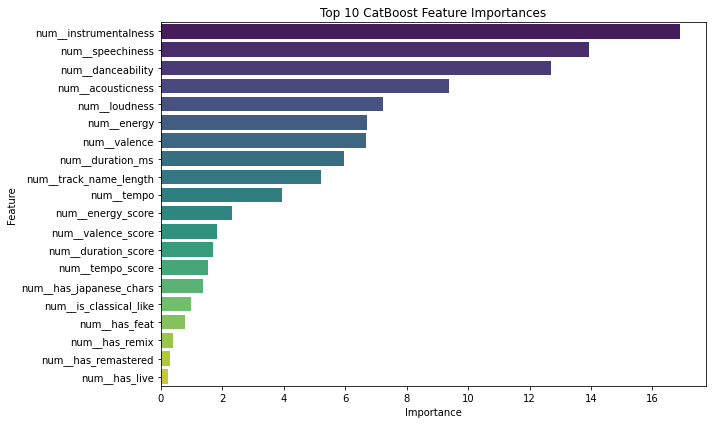

In [54]:
# Таблица с признаками
top_cb_feat_imp = cb_feat_imp.head(20)

# Визуализируем график
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_cb_feat_imp, palette='viridis')
plt.title('CatBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Наибольший вклад в предсказания модели внесли признаки instrumentalness, speechiness и danceability. Наименьший вклад показали сгенерированные признаки: is_classical_like, has_feat, has_remix, has_remastered, has_live.

## Вывод

- На этапе исследования данных проверили баланс классов music_genre, изучили признаки, выявили аномалии и удалили неинформативные колонки (instance_id, obtained_date, track_name, key, liveness, mode).
  
  
- Провели feature engineering: создали бинарные признаки на основе track_name, добавили длину названия трека и провели биннинг числовых признаков (duration_ms, tempo, energy, valence).
  
  
- Обучили три модели (LogisticRegression, RandomForestClassifier, CatBoostClassifier) с Pipeline и GridSearchCV для подбора гиперпараметров. Тюнинг моделей позволил улучшить результаты: лучшая модель — CatBoostClassifier — показала F1 Micro Score 0.494 (baseline — 0.469).
  
  
- DummyClassifier продемонстрировал F1 Micro Score 0.1408, подтверждая, что модель извлекает закономерности, а не угадывает случайно.
  
  
- Feature Importances показали наибольший вклад признаков instrumentalness, speechiness и danceability; наименьший — сгенерированные текстовые признаки (is_classical_like, has_feat, has_remix, has_remastered, has_live).
  
  
- После всех улучшений и предсказаний на тестовой выборке удалось повысить результат в соревновании Kaggle:

    - Было: публичная таблица — F1 micro = 0.4590, приватная — F1 micro = 0.4788

    - Стало: публичная таблица — F1 micro = 0.4935, приватная — F1 micro = 0.5012


Таким образом, комбинация feature engineering, тюнинга гиперпараметров и оценки важности признаков позволила улучшить качество модели и достичь более высоких значений F1 Micro на тестовой выборке.